In [1]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the paths to the JSONL files
input_file_path = 'training_data/training-dataset.jsonl'
output_file_path = 'training_data/training-dataset-filtered.jsonl'

# Check if the output file already exists
if not os.path.exists(output_file_path):
    # List to store filtered data
    filtered_records = []

    # Read the JSONL file and filter the necessary fields
    with open(input_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            record = json.loads(line)

            # Extract required profile fields
            profile = record.get("profile", {})
            filtered_profile = {
                "username": profile.get("username"),
                "follower_count": profile.get("follower_count"),
                "is_verified": profile.get("is_verified"),
                "id": profile.get("id")
            }

            # Extract required post fields
            posts = record.get("posts", [])
            filtered_posts = [
                {
                    "timestamp": post.get("timestamp"),
                    "caption": post.get("caption"),
                    "id": post.get("id"),
                    "comments_count": post.get("comments_count"),
                    "like_count": post.get("like_count"),
                    "media_type": post.get("media_type")
                }
                for post in posts
            ]

            # Combine filtered profile and posts
            filtered_records.append({
                "profile": filtered_profile,
                "posts": filtered_posts
            })

    # Write the filtered data to the output JSONL file
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        for record in filtered_records:
            json_line = json.dumps(record, ensure_ascii=False)
            outfile.write(json_line + '\n')

    print(f"Filtered data has been written to {output_file_path}")
else:
    print(f"Filtered file {output_file_path} already exists.")


Filtered file training_data/training-dataset-filtered.jsonl already exists.


In [2]:
import json
import pandas as pd

# Initialize lists to collect profiles and posts
profiles = []
posts = []

# Open and read the JSONL file line by line
with open('training_data/training-dataset-filtered.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        # Load the JSON data from the current line
        data = json.loads(line)
        
        # Extract profile information
        profile = data.get('profile', {})
        username = profile.get('username')  # Assuming 'username' is the unique identifier
        
        if username:
            profiles.append(profile)
        
            # Extract posts; if no posts, you can skip or handle accordingly
            user_posts = data.get('posts', [])
            
            for post in user_posts:
                # Add the username to each post for linking
                post_record = post.copy()
                post_record['username'] = username
                posts.append(post_record)

# Create DataFrames from the lists without setting 'username' as index
profiles_df = pd.DataFrame(profiles).drop_duplicates(subset=['username'])
posts_df = pd.DataFrame(posts)

# Handle missing 'like_count' in posts
if 'like_count' in posts_df.columns:
    posts_df['like_count'] = posts_df['like_count'].fillna(posts_df['like_count'].mean())

# Display the first few entries of each DataFrame
print("Profiles DataFrame:")
print(profiles_df.info())

print("\nPosts DataFrame:")
print(posts_df.info())

"""
# Example: Retrieve posts along with profile information for a specific username
username_to_query = 'deparmedya'

# Get the profile information
profile_info = profiles_df[profiles_df['username'] == username_to_query]

# Get the posts for that user
user_posts = posts_df[posts_df['username'] == username_to_query]

# Now you can work with both DataFrames as needed
print(profile_info)
print(user_posts)
"""

Profiles DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415 entries, 0 to 5414
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        5415 non-null   object
 1   follower_count  5415 non-null   int64 
 2   is_verified     5415 non-null   bool  
 3   id              5415 non-null   object
dtypes: bool(1), int64(1), object(2)
memory usage: 132.3+ KB
None

Posts DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187302 entries, 0 to 187301
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       187302 non-null  object 
 1   caption         180668 non-null  object 
 2   id              187302 non-null  object 
 3   comments_count  187302 non-null  int64  
 4   like_count      187302 non-null  float64
 5   media_type      187302 non-null  object 
 6   username        187302 non-null  object 
dt

"\n# Example: Retrieve posts along with profile information for a specific username\nusername_to_query = 'deparmedya'\n\n# Get the profile information\nprofile_info = profiles_df[profiles_df['username'] == username_to_query]\n\n# Get the posts for that user\nuser_posts = posts_df[posts_df['username'] == username_to_query]\n\n# Now you can work with both DataFrames as needed\nprint(profile_info)\nprint(user_posts)\n"

In [3]:
def add_avg_like(profiles_df, posts_df):
    """
    Adds the average like count of each profile's posts as a new attribute to profiles_df.

    Parameters:
    - profiles_df (pd.DataFrame): DataFrame containing profile information with 'username' as a unique identifier.
    - posts_df (pd.DataFrame): DataFrame containing posts information with 'username' linking to profiles.

    Returns:
    - pd.DataFrame: Updated profiles_df with a new column 'avg_like_count'.
    """
    # Calculate the average like_count for each username
    avg_likes = posts_df.groupby('username')['like_count'].mean().reset_index()
    avg_likes.rename(columns={'like_count': 'avg_like_count'}, inplace=True)

    # Merge the average likes back into profiles_df
    profiles_df = profiles_df.merge(avg_likes, on='username', how='left')

    # Fill NaN values in 'avg_like_count' with 0 (profiles with no posts)
    profiles_df['avg_like_count'] = profiles_df['avg_like_count'].fillna(0)

    return profiles_df

In [4]:
def add_max_like(profiles_df, posts_df):
    """
    Adds the maximum like count of each profile's posts as a new attribute to profiles_df.

    Parameters:
    - profiles_df (pd.DataFrame): DataFrame containing profile information with 'username' as a unique identifier.
    - posts_df (pd.DataFrame): DataFrame containing posts information with 'username' linking to profiles.

    Returns:
    - pd.DataFrame: Updated profiles_df with a new column 'max_like_count'.
    """
    # Calculate the maximum like_count for each username
    max_likes = posts_df.groupby('username')['like_count'].max().reset_index()
    max_likes.rename(columns={'like_count': 'max_like_count'}, inplace=True)

    # Merge the maximum likes back into profiles_df
    profiles_df = profiles_df.merge(max_likes, on='username', how='left')

    # Fill NaN values in 'max_like_count' with 0 (profiles with no posts)
    profiles_df['max_like_count'] = profiles_df['max_like_count'].fillna(0)

    return profiles_df

In [5]:
def add_min_like(profiles_df, posts_df):
    """
    Adds the minimum like count of each profile's posts as a new attribute to profiles_df.

    Parameters:
    - profiles_df (pd.DataFrame): DataFrame containing profile information with 'username' as a unique identifier.
    - posts_df (pd.DataFrame): DataFrame containing posts information with 'username' linking to profiles.

    Returns:
    - pd.DataFrame: Updated profiles_df with a new column 'min_like_count'.
    """
    # Calculate the minimum like_count for each username
    min_likes = posts_df.groupby('username')['like_count'].min().reset_index()
    min_likes.rename(columns={'like_count': 'min_like_count'}, inplace=True)

    # Merge the minimum likes back into profiles_df
    profiles_df = profiles_df.merge(min_likes, on='username', how='left')

    # Fill NaN values in 'min_like_count' with 0 (profiles with no posts)
    profiles_df['min_like_count'] = profiles_df['min_like_count'].fillna(0)

    return profiles_df

In [6]:
def add_log_follower_count(profiles_df, posts_df):
    """
    Adds the logarithm (base 10) of the follower count as a new attribute to profiles_df.

    Parameters:
    - profiles_df (pd.DataFrame): DataFrame containing profile information with 'follower_count'.
    - posts_df (pd.DataFrame): Unused in this function but kept for signature consistency.

    Returns:
    - pd.DataFrame: Updated profiles_df with a new column 'log_follower_count'.
    """
    # Compute log10 of follower_count. Adding 1 to avoid log(0).
    profiles_df['log_follower_count'] = np.log10(profiles_df['follower_count'] + 1)

    return profiles_df

In [7]:
def add_avg_comment(profiles_df, posts_df):
    """
    Adds the average comment count of each profile's posts as a new attribute to profiles_df.

    Parameters:
    - profiles_df (pd.DataFrame): DataFrame containing profile information with 'username' as a unique identifier.
    - posts_df (pd.DataFrame): DataFrame containing posts information with 'username' linking to profiles.

    Returns:
    - pd.DataFrame: Updated profiles_df with a new column 'avg_comment_count'.
    """
    # Calculate the average comments_count for each username
    avg_comments = posts_df.groupby('username')['comments_count'].mean().reset_index()
    avg_comments.rename(columns={'comments_count': 'avg_comment_count'}, inplace=True)

    # Merge the average comments back into profiles_df
    profiles_df = profiles_df.merge(avg_comments, on='username', how='left')

    # Fill NaN values in 'avg_comment_count' with 0 (profiles with no posts)
    profiles_df['avg_comment_count'] = profiles_df['avg_comment_count'].fillna(0)

    return profiles_df

In [8]:
import bisect
import numpy as np
import pandas as pd

def add_reach_like_count(train_posts, val_posts, reach):
    """
    Adds a new feature 'reach_like_count' to val_posts based on surrounding posts' like counts.

    For each post in val_posts, computes the average of like_counts of up to 4 posts before and
    after the post in the training data, in log space, then exponentiates back and rounds to integer.

    Parameters:
    - train_posts (pd.DataFrame): Training posts with 'username', 'timestamp', 'like_count'.
    - val_posts (pd.DataFrame): Validation posts with 'username', 'timestamp'.

    Returns:
    - val_posts (pd.DataFrame): Validation posts with a new column 'reach_like_count'.
    """
    # Ensure 'timestamp' is in datetime format
    train_posts['timestamp'] = pd.to_datetime(train_posts['timestamp'])
    val_posts['timestamp'] = pd.to_datetime(val_posts['timestamp'])

    # Sort train_posts by username and timestamp
    train_posts_sorted = train_posts.sort_values(['username', 'timestamp']).reset_index(drop=True)

    # Create a dictionary mapping username to list of timestamps and like_counts
    user_train_posts = {}
    for username, group in train_posts_sorted.groupby('username'):
        timestamps = group['timestamp'].tolist()
        like_counts = group['like_count'].tolist()
        user_train_posts[username] = (timestamps, like_counts)

    # Define a function to compute reach_like_count for a single row
    def compute_reach_like(row):
        username = row['username']
        timestamp = row['timestamp']
        if username not in user_train_posts:
            # Assign global average later
            return np.nan
        timestamps, like_counts = user_train_posts[username]
        # Find the insertion point
        idx = bisect.bisect_left(timestamps, timestamp)
        # Get reach before and reach after (excluding the post itself)
        start = max(idx - reach, 0)
        end = min(idx + reach, len(timestamps))
        surrounding_likes = like_counts[start:idx] + like_counts[idx:end]
        if len(surrounding_likes) == 0:
            return np.nan
        # Compute average in log space
        log_likes = np.log1p(surrounding_likes)
        avg_log = np.mean(log_likes)
        # Exponentiate back
        avg_like = np.expm1(avg_log)
        # DONT Round to integer here, model can benefit from added precision, only round when saving output file
        # avg_like_rounded = int(round(avg_like))
        return avg_like

    # Apply the function to val_posts
    val_posts['reach_like_count'] = val_posts.apply(compute_reach_like, axis=1)

    # Compute global average from training posts in log space
    global_avg_like = np.round(np.expm1(np.mean(np.log1p(train_posts['like_count'])))).astype(int)

    # Fill NaN values with global average
    val_posts['reach_like_count'] = val_posts['reach_like_count'].fillna(global_avg_like).astype(int)

    return val_posts


In [9]:
def feature_engineering(train_posts, val_posts, profiles_df):
    """
    Performs feature engineering by adding average like, average comment counts, and reach_like_count to both training and validation posts.

    Parameters:
    - train_posts (pd.DataFrame): Training posts.
    - val_posts (pd.DataFrame): Validation posts.
    - profiles_df (pd.DataFrame): Profiles DataFrame containing profile information.

    Returns:
    - train_posts (pd.DataFrame): Training posts with added features.
    - val_posts (pd.DataFrame): Validation posts with added features.
    """
    # Compute average like and comment counts from training posts
    train_profiles = profiles_df.copy()
    train_profiles = add_avg_like(train_profiles, train_posts)       # Adds 'avg_like_count'
    train_profiles = add_avg_comment(train_profiles, train_posts)   # Adds 'avg_comment_count'

    # Calculate global averages from training data
    global_avg_like = train_profiles['avg_like_count'].mean()
    global_avg_comment = train_profiles['avg_comment_count'].mean()

    # Merge the average metrics into training and validation posts based on 'username'
    train_posts = train_posts.merge(
        train_profiles[['username', 'avg_like_count', 'avg_comment_count']],
        on='username',
        how='left'
    )
    val_posts = val_posts.merge(
        train_profiles[['username', 'avg_like_count', 'avg_comment_count']],
        on='username',
        how='left'
    )

    # Assign global averages to profiles not present in training data
    train_posts['avg_like_count'] = train_posts['avg_like_count'].fillna(global_avg_like)
    train_posts['avg_comment_count'] = train_posts['avg_comment_count'].fillna(global_avg_comment)

    val_posts['avg_like_count'] = val_posts['avg_like_count'].fillna(global_avg_like)
    val_posts['avg_comment_count'] = val_posts['avg_comment_count'].fillna(global_avg_comment)

    # Add the new feature 'reach_like_count'
    train_posts = add_reach_like_count(train_posts, train_posts, 8)  # Assuming add_reach_like_count can handle this
    val_posts = add_reach_like_count(train_posts, val_posts, 8)

    # Merge additional profile features: 'follower_count' and 'is_verified'
    train_posts = train_posts.merge(
        profiles_df[['username', 'follower_count', 'is_verified']],
        on='username',
        how='left'
    )
    val_posts = val_posts.merge(
        profiles_df[['username', 'follower_count', 'is_verified']],
        on='username',
        how='left'
    )

    return train_posts, val_posts


In [10]:
def log_mse_like_counts(y_true, y_pred):
    """
    Calculates the Log Mean Squared Error between true and predicted values.

    Parameters:
    - y_true (array-like): Actual like counts.
    - y_pred (array-like): Predicted like counts.

    Returns:
    - float: Log MSE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Ensure no negative values before log
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    log_y_true = np.log1p(y_true)
    log_y_pred = np.log1p(y_pred)
    squared_errors = (log_y_true - log_y_pred) ** 2
    return np.mean(squared_errors)

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import joblib  # Optional: For saving the trained model

def train_ml_model(train_posts, val_posts):
    """
    Trains a machine learning model to predict 'like_count' using engineered features and profile data.

    Parameters:
    - train_posts (pd.DataFrame): Training posts with engineered features.
    - val_posts (pd.DataFrame): Validation posts with engineered features.

    Returns:
    - y_pred (np.ndarray): Predicted like counts for the validation posts.
    """
    # Define feature columns
    feature_cols = [
        'reach_like_count',      # Engineered feature
        'avg_like_count',       # Engineered feature
        'avg_comment_count',    # Engineered feature
        'follower_count',       # From profiles
        'is_verified',          # From profiles
        'comments_count',       # From posts
        'media_type'            # From posts (categorical)
    ]

    # Prepare the feature matrices
    X_train = train_posts[feature_cols].copy()
    y_train = train_posts['like_count'].values
    X_val = val_posts[feature_cols].copy()
    y_val = val_posts['like_count'].values

    # Define preprocessing for numerical and categorical features
    numerical_features = [
        'reach_like_count',
        'avg_like_count',
        'avg_comment_count',
        'follower_count',
        'comments_count'
    ]
    categorical_features = ['is_verified', 'media_type']

    # Create preprocessing pipelines
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Define and train the model within a pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_val)

    # Optionally, evaluate the model on the validation set
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"Validation RMSE: {rmse}")

    return y_pred

# Optional: Function to save the trained model
def save_model(model, filename):
    joblib.dump(model, filename)

# Optional: Function to load a saved model
def load_model(filename):
    return joblib.load(filename)

In [12]:
import bisect
import numpy as np
from sklearn.model_selection import KFold  # We'll not use this directly for splitting
import pandas as pd

# Assuming posts_df and profiles_df are already defined and loaded

# Ensure 'username' is unique in profiles_df
assert profiles_df['username'].is_unique, "Username in profiles_df must be unique."

# Reset index to ensure proper splitting
posts_df = posts_df.reset_index(drop=True)
profiles_df = profiles_df.reset_index(drop=True)

# Define number of folds
num_folds = 5
np.random.seed(42)  # For reproducibility

# Initialize list of lists to hold indices for each fold's test set
folds_test_indices = [[] for _ in range(num_folds)]

# Group posts by user and assign one post per user to a random fold
for user, group in posts_df.groupby('username'):
    # Randomly select one post from this user's posts
    one_post = group.sample(n=1, random_state=42)
    post_idx = one_post.index[0]
    
    # Randomly assign this post to one of the folds
    fold_assignment = np.random.choice(num_folds)
    folds_test_indices[fold_assignment].append(post_idx)

# Prepare to store log MSE scores for each fold
log_mse_scores = []

# Start custom Cross-Validation based on our fold assignments
for fold in range(num_folds):
    print(f"\nProcessing Fold {fold + 1}...")
    
    # Identify test indices for the current fold
    test_indices = folds_test_indices[fold]
    
    # The remaining indices form the training set
    train_indices = posts_df.index.difference(test_indices)
    
    # Split posts into training and validation sets based on indices
    train_posts = posts_df.loc[train_indices].copy()
    val_posts = posts_df.loc[test_indices].copy()

    line_count = len(train_posts)
    print(f"Training data size: {line_count}")

    line_count = len(val_posts)
    print(f"Test data size: {line_count}")
    
    # Feature Engineering
    train_posts, val_posts = feature_engineering(train_posts, val_posts, profiles_df)
    
    # Machine Learning Prediction
    y_pred_fold = train_ml_model(train_posts, val_posts)
    y_true_fold = val_posts['like_count'].values

    """
    mean_like = train_posts['like_count'].mean()
    y_pred_baseline = np.full_like(y_true_fold, mean_like)
    baseline_rmse = np.sqrt(mean_squared_error(y_true_fold, y_pred_baseline))
    baseline_log_mse = log_mse_like_counts(y_true_fold, y_pred_baseline)
    print(f"Fold {fold} Mean baseline model Log MSE: {baseline_log_mse:.6f}")
    
    median_like = train_posts['like_count'].median()
    y_pred_median = np.full_like(y_true_fold, median_like)
    median_rmse = np.sqrt(mean_squared_error(y_true_fold, y_pred_median))
    median_log_mse = log_mse_like_counts(y_true_fold, y_pred_median)
    print(f"Fold {fold} Median baseline model Log MSE: {median_log_mse:.6f}")

    y_pred_reach = val_posts['reach_like_count'].values
    reach_rmse = np.sqrt(mean_squared_error(y_true_fold, y_pred_reach))
    reach_log_mse = log_mse_like_counts(y_true_fold, y_pred_reach)
    print(f"Fold {fold} Reach Like Count baseline Log MSE: {reach_log_mse:.6f}")
    """
    
    y_pred_avg = val_posts['avg_like_count'].values
    avg_rmse = np.sqrt(mean_squared_error(y_true_fold, y_pred_avg))
    avg_mse = log_mse_like_counts(y_true_fold, y_pred_avg)
    print(f"Fold {fold + 1} Avg baseline RMSE: {avg_rmse:.6f}")
    print(f"Fold {fold + 1} Avg baseline Log MSE: {avg_mse:.6f}")
    
    # Calculate Log MSE for the current fold
    fold_log_mse = log_mse_like_counts(y_true_fold, y_pred_fold)
    log_mse_scores.append(fold_log_mse)
    print(f"Fold {fold + 1} Log MSE: {fold_log_mse:.6f}")

# Calculate and display the average Log MSE across all folds
average_log_mse = np.mean(log_mse_scores)
print(f"\nAverage Log MSE across {num_folds} folds: {average_log_mse:.6f}")


Processing Fold 1...
Training data size: 186214
Test data size: 1088
Validation RMSE: 15542.946524118888
Fold 1 Avg baseline RMSE: 25398.200669
Fold 1 Avg baseline Log MSE: 0.837356
Fold 1 Log MSE: 0.463605

Processing Fold 2...
Training data size: 186259
Test data size: 1043
Validation RMSE: 30763.259602035538
Fold 2 Avg baseline RMSE: 14914.841539
Fold 2 Avg baseline Log MSE: 0.766655
Fold 2 Log MSE: 0.478621

Processing Fold 3...
Training data size: 186234
Test data size: 1068
Validation RMSE: 12008.395591373242
Fold 3 Avg baseline RMSE: 19887.547224
Fold 3 Avg baseline Log MSE: 0.665240
Fold 3 Log MSE: 0.357441

Processing Fold 4...
Training data size: 186191
Test data size: 1111
Validation RMSE: 27708.93047643322
Fold 4 Avg baseline RMSE: 24749.315029
Fold 4 Avg baseline Log MSE: 0.821724
Fold 4 Log MSE: 0.447230

Processing Fold 5...
Training data size: 186199
Test data size: 1103
Validation RMSE: 12559.846737224994
Fold 5 Avg baseline RMSE: 16934.317442
Fold 5 Avg baseline Log 

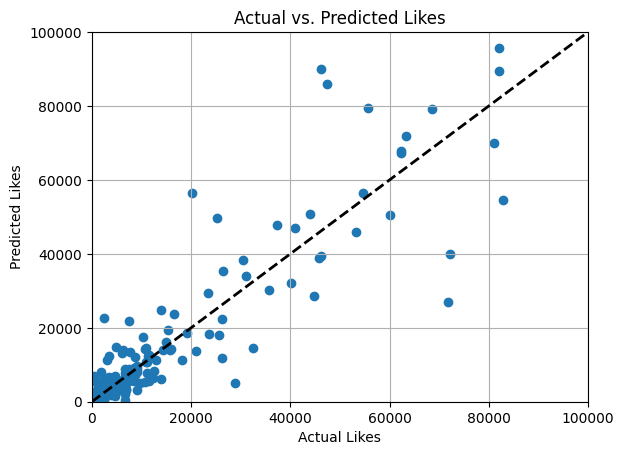

In [13]:
import matplotlib.pyplot as plt

plt.scatter(y_true_fold, y_pred_fold)
plt.plot([y_true_fold.min(), y_true_fold.max()], 
         [y_true_fold.min(), y_true_fold.max()], 'k--', lw=2)
plt.xlim(0, 1e5)  # Zoom in on x-axis between 0 and 1 million
plt.ylim(0, 1e5)  # Zoom in on y-axis between 0 and 1 million
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.title('Actual vs. Predicted Likes')
plt.grid(True)
plt.show()


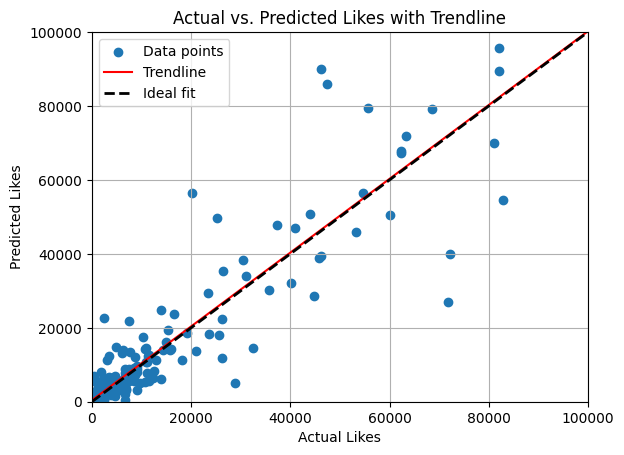

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true_fold and y_pred_fold are your data arrays
# Fit a linear regression line (trendline)
coefficients = np.polyfit(y_true_fold, y_pred_fold, 1)  # Degree 1 for a linear fit
trendline = np.poly1d(coefficients)

# Generate x values for the trendline
x_vals = np.linspace(y_true_fold.min(), y_true_fold.max(), 100)
y_vals = trendline(x_vals)

# Plot scatter and trendline
plt.scatter(y_true_fold, y_pred_fold, label='Data points')
plt.plot(x_vals, y_vals, 'r-', label='Trendline')  # Red trendline
plt.plot([y_true_fold.min(), y_true_fold.max()], 
         [y_true_fold.min(), y_true_fold.max()], 'k--', lw=2, label='Ideal fit')
plt.xlim(0, 1e5)  # Zoom in if needed
plt.ylim(0, 1e5)
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.title('Actual vs. Predicted Likes with Trendline')
plt.legend()
plt.grid(True)
plt.show()


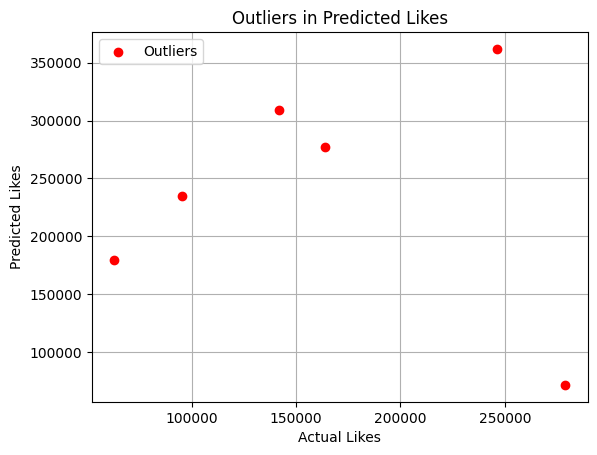

Number of outliers: 6


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
residuals = y_pred_fold - y_true_fold

# Define a threshold for outliers (e.g., absolute residual > 100,000)
threshold = 1e5
outlier_mask = np.abs(residuals) > threshold

# Extract outliers
outlier_x = y_true_fold[outlier_mask]
outlier_y = y_pred_fold[outlier_mask]

# Scatter plot for outliers
plt.scatter(outlier_x, outlier_y, color='red', label='Outliers')
plt.xlabel('Actual Likes')
plt.ylabel('Predicted Likes')
plt.title('Outliers in Predicted Likes')
plt.grid(True)
plt.legend()
plt.show()


# Calculate residuals
residuals = y_pred_fold - y_true_fold

# Define a threshold for outliers (e.g., absolute residual > 100,000)
outlier_mask = np.abs(residuals) > threshold

# Count the number of outliers
outlier_count = np.sum(outlier_mask)
print(f"Number of outliers: {outlier_count}")


In [16]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

def train_and_predict(train_posts, test_posts):
    """
    Trains a machine learning model on the training data and predicts like counts for the test posts.

    Parameters:
    - train_posts (pd.DataFrame): Training posts with engineered features and 'like_count'.
    - test_posts (pd.DataFrame): Test posts with engineered features (without 'like_count').

    Returns:
    - y_pred (np.ndarray): Predicted like counts for the test posts.
    - trained_model (Pipeline): The trained model pipeline.
    """
    # Define feature columns
    feature_cols = [
        'reach_like_count',  
        'avg_like_count',    
        'avg_comment_count', 
        'follower_count',    
        'is_verified',       
        'comments_count',    
        'media_type'         
    ]

    X_train = train_posts[feature_cols].copy()
    y_train = train_posts['like_count'].values
    X_test = test_posts[feature_cols].copy()

    # Define preprocessing for numerical and categorical features
    numerical_features = [
        'reach_like_count',
        'avg_like_count',
        'avg_comment_count',
        'follower_count',
        'comments_count'
    ]
    categorical_features = ['is_verified', 'media_type']

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Train model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    return y_pred, model

# Example usage:

# Ensure 'username' is unique in profiles_df
assert profiles_df['username'].is_unique, "Username in profiles_df must be unique."

# Reset indices for consistency
posts_df = posts_df.reset_index(drop=True)
profiles_df = profiles_df.reset_index(drop=True)

# ========= TRAINING ON THE ENTIRE DATASET =========
print("Applying feature engineering on training data...")
# Assuming feature_engineering function exists; applying it on entire training set
# Here, we're preparing data for training; if feature_engineering requires a validation set,
# you can pass an empty DataFrame or replicate the training set for test_posts as a placeholder.
train_posts = posts_df.copy()
# Create an empty DataFrame with same columns as posts_df for placeholder (if needed)
dummy_val_posts = posts_df.iloc[:0].copy()

# Apply feature engineering to training data (and dummy validation if necessary)
train_posts_fe, _ = feature_engineering(train_posts, dummy_val_posts, profiles_df)

# ========= READING AND PREPARING TEST DATA =========
print("Reading test data...")
test_file = "test_data/test-regression-round3.jsonl"
test_posts_list = []

with open(test_file, 'r', encoding='utf-8') as f:
    for line in f:
        post = json.loads(line.strip())
        test_posts_list.append(post)

test_posts = pd.DataFrame(test_posts_list)
test_posts = test_posts.reset_index(drop=True)

print("Applying feature engineering on test data...")
# Apply feature engineering on test data using the same profiles_df as used for training
# Note: We don't need to re-engineer training data here, as it's done above.
_, test_posts_fe = feature_engineering(train_posts, test_posts, profiles_df)

# ========= PREDICTION =========
print("Predicting like counts for test data...")
y_pred_test, trained_model = train_and_predict(train_posts_fe, test_posts_fe)

# ========= SAVING OUTPUT =========
print("Saving predictions to regressionoutput.json...")
predictions = {}
for idx, row in test_posts_fe.iterrows():
    # Map each post's id to its predicted like count
    predictions[row['id']] = int(y_pred_test[idx])

output_file = "regressionoutput.json"
with open(output_file, 'w', encoding='utf-8') as f_out:
    json.dump(predictions, f_out, indent=4)

print(f"Predictions saved to {output_file}.")


Applying feature engineering on training data...
Reading test data...
Applying feature engineering on test data...
Predicting like counts for test data...
Saving predictions to regressionoutput.json...
Predictions saved to regressionoutput.json.
